In [54]:
import mlflow
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.image as mpimg
import math

In [55]:
mlflow.set_tracking_uri("sqlite:///../mlflow.db")

EXP_NAME = "Emotion_Detection_Transformers"

experiment = mlflow.get_experiment_by_name(EXP_NAME)

if experiment is None:
    print("Eksperiment nije pronadjen! Pogrsno ime ili putanja do baze.")
else:
    df = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="attributes.status = 'FINISHED'"
    )
    
    cols_to_keep = [
        'tags.mlflow.runName', 
        'params.model',
        'params.description',
        'params.learning_rate', 
        'params.batch_size', 
        'params.max_len',
        'params.optimizer',
        'metrics.avg_accuracy', 
        'metrics.avg_f1', 
        'metrics.avg_train_time_sec',
        'metrics.model_size_mb',
        'artifact_uri',
        'end_time'
    ]
    
    existing_cols = [c for c in cols_to_keep if c in df.columns]
    df_filtered = df[existing_cols].copy()
    
    rename_map = {
        'tags.mlflow.runName': 'Name',
        'params.description': 'Description',
        'params.model': 'Model',
        'params.learning_rate': 'LR',
        'params.batch_size': 'Batch',
        'params.max_len': 'Len',
        'metrics.avg_accuracy': 'Accuracy',
        'metrics.avg_f1': 'F1 Score',
        'metrics.avg_train_time_sec': 'Time(s)',
        'metrics.model_size_mb': 'Size(MB)'
    }
    df_filtered = df_filtered.rename(columns=rename_map)

    #filtriramo prethodne probne eksperimente po nazivu
    #novi imaju timestamp u imenu i konzistentne metrike
    timestamp_pattern = r'\d{8}_\d{6}'
    df_filtered = df_filtered[df_filtered['Name'].str.contains(timestamp_pattern, regex=True)]
    
    #kolone koje ne prikazujemo
    cols_to_hide = ['artifact_uri', 'end_time']

    #tabela sortirana po f1 score
    df_f1 = df_filtered.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
    df_display_f1 = df_f1.drop(columns=[c for c in cols_to_hide if c in df_f1.columns])

    #tabela sortirana po accuracy
    df_acc = df_filtered.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
    df_display_acc = df_acc.drop(columns=[c for c in cols_to_hide if c in df_acc.columns])
    
    print(f"Ukupno pronadjeno {len(df_filtered)} uspesnih run-ova.\n")
    
    def style_table(dataframe):
        return dataframe.style.background_gradient(subset=['Accuracy', 'F1 Score'], cmap='Greens') \
            .format({'Accuracy': '{:.4f}', 'F1 Score': '{:.4f}', 'Time(s)': '{:.1f}'}) \
            .set_properties(**{'text-align': 'left'}) \
            .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])


    print("Tabela rangirana prema F1 Score")
    display(style_table(df_display_f1))
    
    print("Tabela rangirana prema Accuracy")
    display(style_table(df_display_acc))

Ukupno pronadjeno 8 uspesnih run-ova.

Tabela rangirana prema F1 Score


,Name,Model,Description,LR,Batch,Len,Accuracy,F1 Score,Time(s),Size(MB)
0,Bert_Tiny_20260224_224237,bert-tiny,"Optimizovani parametri, 4 folda, 4 epohe",2e-05,32,128,0.9854,0.9854,291.1,16.742214
1,Bert_Mini_20260224_233549,bert-mini,"Bert Mini, optimalni hiperparametri",2e-05,64,64,0.9831,0.9831,320.4,42.626980
2,Bert_Tiny_20260225_001750,bert-tiny,"Bert Tiny, hiperparametri optimizivani za preciznost",2e-05,32,128,0.9783,0.9783,187.7,16.742214
3,Bert_Tiny_20260224_204912,bert-tiny,"max_len je sada 32 umsto 128, model ce gledati samo prvih tridesetak reci, trening bi trebalo da bude brzi",2e-05,32,32,0.9412,0.9413,81.2,16.742214
4,Bert_Tiny_20260224_231135,bert-tiny,"Brzo treniranje, manja tacnost",5e-05,64,20,0.8944,0.8943,26.5,16.742214
5,Bert_Tiny_20260225_005311,bert-tiny,Test crtanja learning curve-a,5e-05,64,16,0.8594,0.8594,18.8,16.742214
6,Bert_Tiny_20260224_221622,bert-tiny,"Amnezija - Kratak kontekst, model ce videti samo prvih 5 reci",2e-05,32,6,0.7912,0.7908,69.0,16.742214
7,Bert_Tiny_20260224_211624,bert-tiny,"Eksplozija - Preveliki learning rate, ROC kriva bi trebalo da bude blize dijagonali, loss f-ja bi trebalo da osciluje",0.01,16,128,0.1413,0.0613,982.5,16.742214


Tabela rangirana prema Accuracy


,Name,Model,Description,LR,Batch,Len,Accuracy,F1 Score,Time(s),Size(MB)
0,Bert_Tiny_20260224_224237,bert-tiny,"Optimizovani parametri, 4 folda, 4 epohe",2e-05,32,128,0.9854,0.9854,291.1,16.742214
1,Bert_Mini_20260224_233549,bert-mini,"Bert Mini, optimalni hiperparametri",2e-05,64,64,0.9831,0.9831,320.4,42.626980
2,Bert_Tiny_20260225_001750,bert-tiny,"Bert Tiny, hiperparametri optimizivani za preciznost",2e-05,32,128,0.9783,0.9783,187.7,16.742214
3,Bert_Tiny_20260224_204912,bert-tiny,"max_len je sada 32 umsto 128, model ce gledati samo prvih tridesetak reci, trening bi trebalo da bude brzi",2e-05,32,32,0.9412,0.9413,81.2,16.742214
4,Bert_Tiny_20260224_231135,bert-tiny,"Brzo treniranje, manja tacnost",5e-05,64,20,0.8944,0.8943,26.5,16.742214
5,Bert_Tiny_20260225_005311,bert-tiny,Test crtanja learning curve-a,5e-05,64,16,0.8594,0.8594,18.8,16.742214
6,Bert_Tiny_20260224_221622,bert-tiny,"Amnezija - Kratak kontekst, model ce videti samo prvih 5 reci",2e-05,32,6,0.7912,0.7908,69.0,16.742214
7,Bert_Tiny_20260224_211624,bert-tiny,"Eksplozija - Preveliki learning rate, ROC kriva bi trebalo da bude blize dijagonali, loss f-ja bi trebalo da osciluje",0.01,16,128,0.1413,0.0613,982.5,16.742214


In [56]:
target_run_names = [
    "Bert_Tiny_20260225_001750", 
    "Bert_Tiny_20260224_224237", 
    "Bert_Mini_20260224_233549", 
    "Bert_Tiny_20260224_204912", 
    "Bert_Tiny_20260224_231135", 
    "Bert_Tiny_20260224_221622", 
    "Bert_Tiny_20260224_211624"  
]

run_descriptions = {
    "Bert_Tiny_20260225_001750": "Tiny - Preciznost (3 epohe)",
    "Bert_Tiny_20260224_224237": "Tiny - Najbolji Accuracy (4 epohe)",
    "Bert_Mini_20260224_233549": "Mini - Optimalni",
    "Bert_Tiny_20260224_204912": "Tiny - Kratak Len (32)",
    "Bert_Tiny_20260224_231135": "Tiny - Najbrzi (Speed)",
    "Bert_Tiny_20260224_221622": "Tiny - Amnezija (Context=5)",
    "Bert_Tiny_20260224_211624": "Tiny - Eksplozija (High LR)"
}

run_data = []

print("Prikupljanje grafika i parametara...")

for name in target_run_names:
    run_row = df[df['tags.mlflow.runName'].str.contains(name, regex=False)]
    
    if run_row.empty:
        print(f"Run '{name}' nije pronadjen u DataFrame-u.")
        continue
    
    row = run_row.iloc[0]
    run_id = row['run_id']
    full_name = row['tags.mlflow.runName']
    
    params = {
        "Model": row.get('params.model', 'N/A'),
        "LR": row.get('params.learning_rate', 'N/A'),
        "Batch": row.get('params.batch_size', 'N/A'),
        "Len": row.get('params.max_len', 'N/A'),
        "Acc": row.get('metrics.avg_accuracy', 0.0),
        "F1": row.get('metrics.avg_f1', 0.0),
        "Time": row.get('metrics.avg_train_time_sec', 0.0),
        "ModelSize": row.get('metrics.model_size_mb', 0.0)
    }

    artifacts = {}
    for img_name in ["confusion_matrix.png", "learning_curve.png", "roc_curve.png"]:
        try:
            local_path = mlflow.artifacts.download_artifacts(run_id=run_id, artifact_path=img_name)
            artifacts[img_name] = local_path
        except Exception:
            artifacts[img_name] = None
            
    run_data.append({
        "name": full_name,
        "desc": run_descriptions.get(name, name),
        "params": params,
        "images": artifacts
    })

print(f"Podaci prikupljeni za {len(run_data)} run-ova.")

def plot_grid(data_list, image_key, title_main):
    n = len(data_list)
    cols = 3
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 7 * rows))
    fig.suptitle(title_main, fontsize=24, y=1.02)
    axes = axes.flatten()
    
    for i, item in enumerate(data_list):
        ax = axes[i]
        img_path = item['images'].get(image_key)
        
        if img_path:
            img = mpimg.imread(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Nema slike", ha='center', va='center')
            
        ax.axis('off')
        
        ax.set_title(item['desc'], fontsize=16, fontweight='bold', pad=20)
        
        p = item['params']
        acc_val = f"{float(p['Acc']):.3f}" if p['Acc'] != 'N/A' else 'N/A'
        f1_val = f"{float(p['F1']):.3f}" if p['F1'] != 'N/A' else 'N/A'
        
        param_text = (
            f"Model: {p['Model']} | LR: {p['LR']} | Len: {p['Len']}\n"
            f"Acc: {acc_val} | F1: {f1_val} | Time: {p['Time']:.1f}s | Model Size: {p['ModelSize']:.1f}MB"
        )
        ax.text(0.5, -0.15, param_text, transform=ax.transAxes, 
                ha='center', va='top', fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.3", fc="#f0f0f0", ec="gray", alpha=0.5))

    for i in range(len(data_list), len(axes)):
        axes[i].axis('off')

    plt.subplots_adjust(top=0.92, bottom=0.05, hspace=0.5, wspace=0.2)
    plt.show()

Prikupljanje grafika i parametara...


Podaci prikupljeni za 7 run-ova.


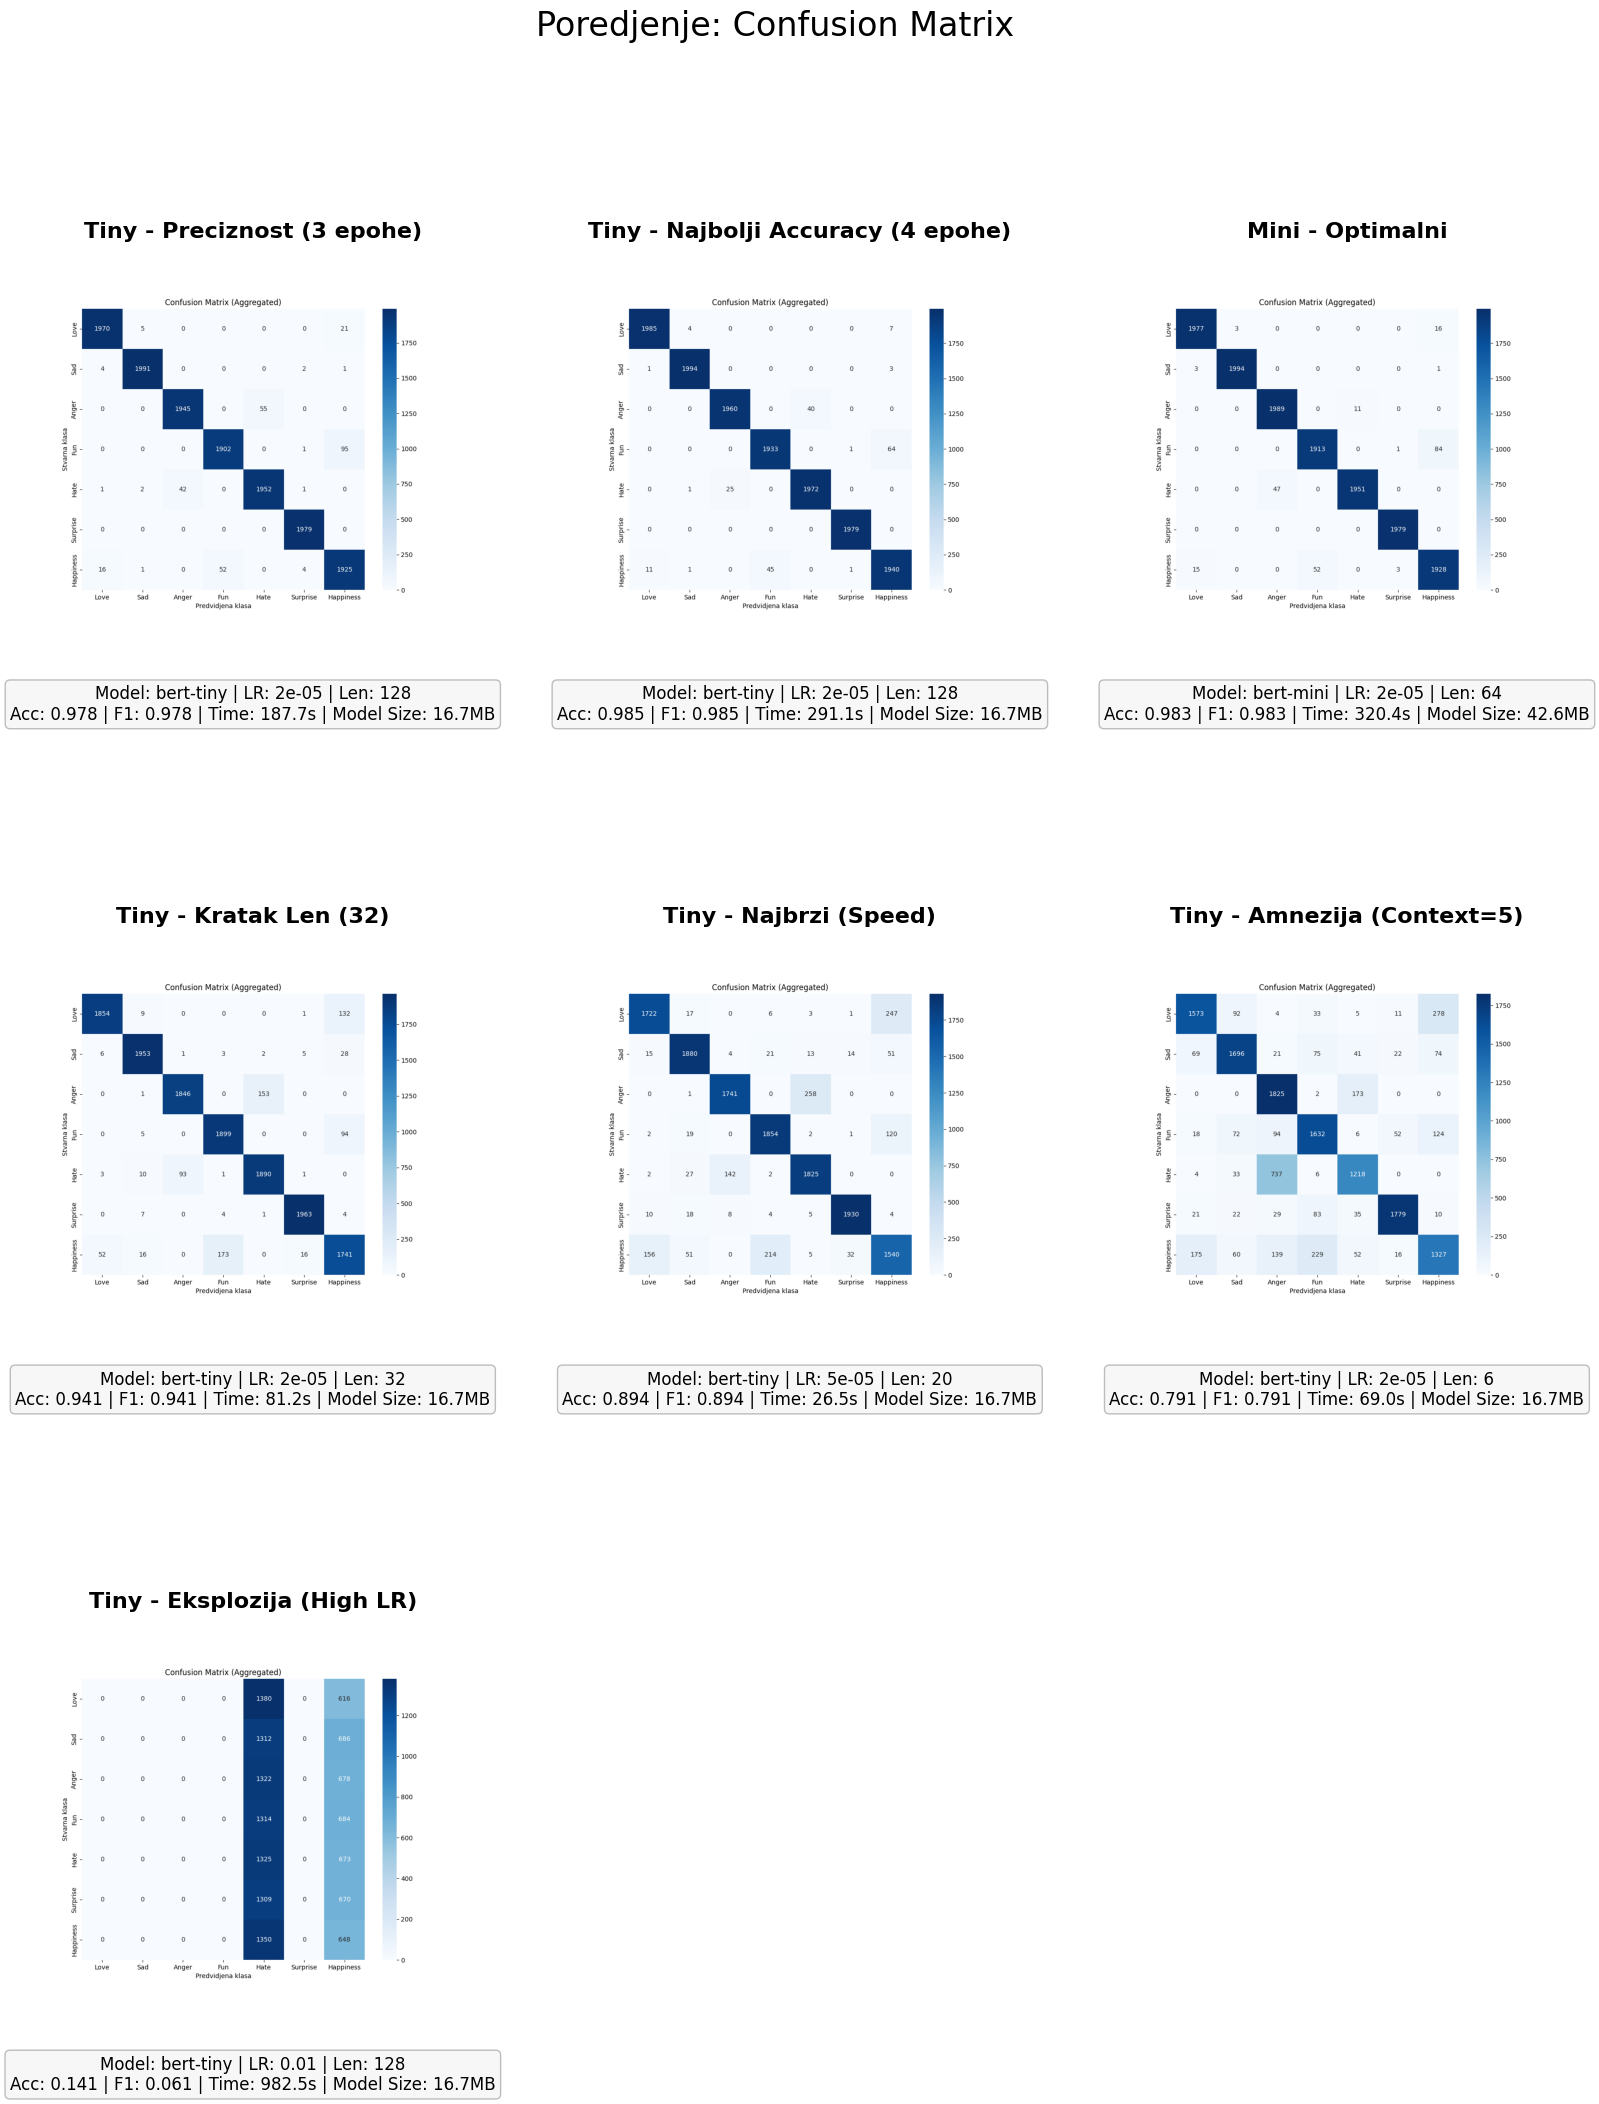

In [57]:
plot_grid(run_data, "confusion_matrix.png", "Poredjenje: Confusion Matrix")

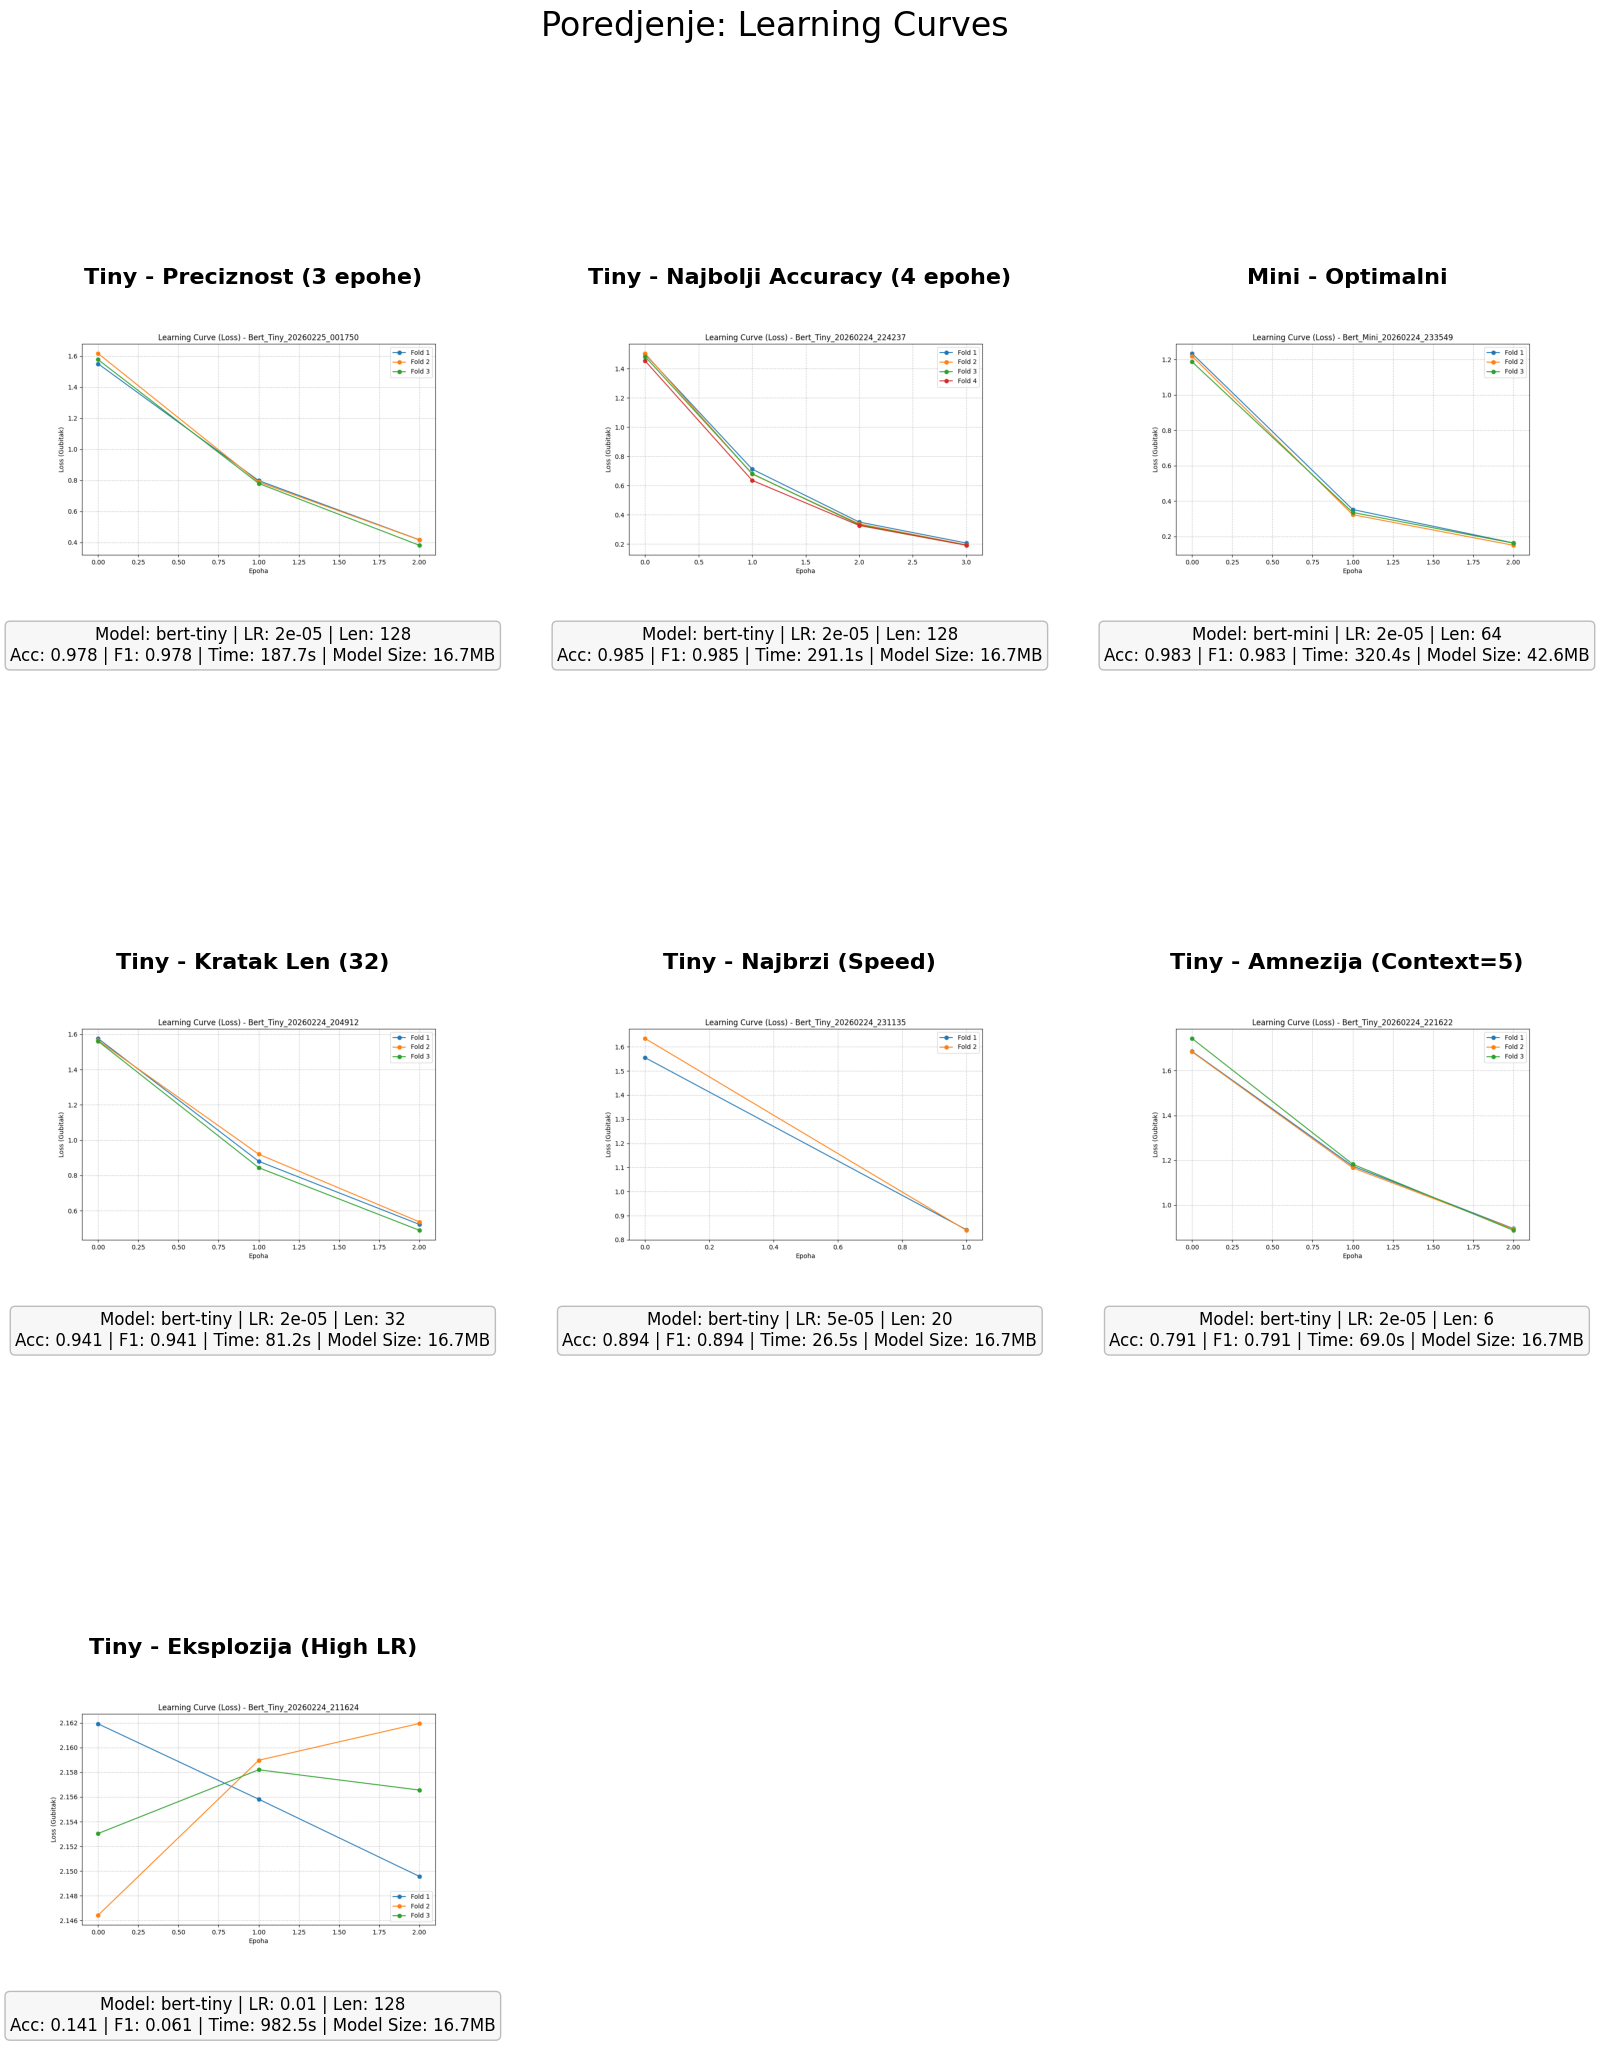

In [58]:
plot_grid(run_data, "learning_curve.png", "Poredjenje: Learning Curves")

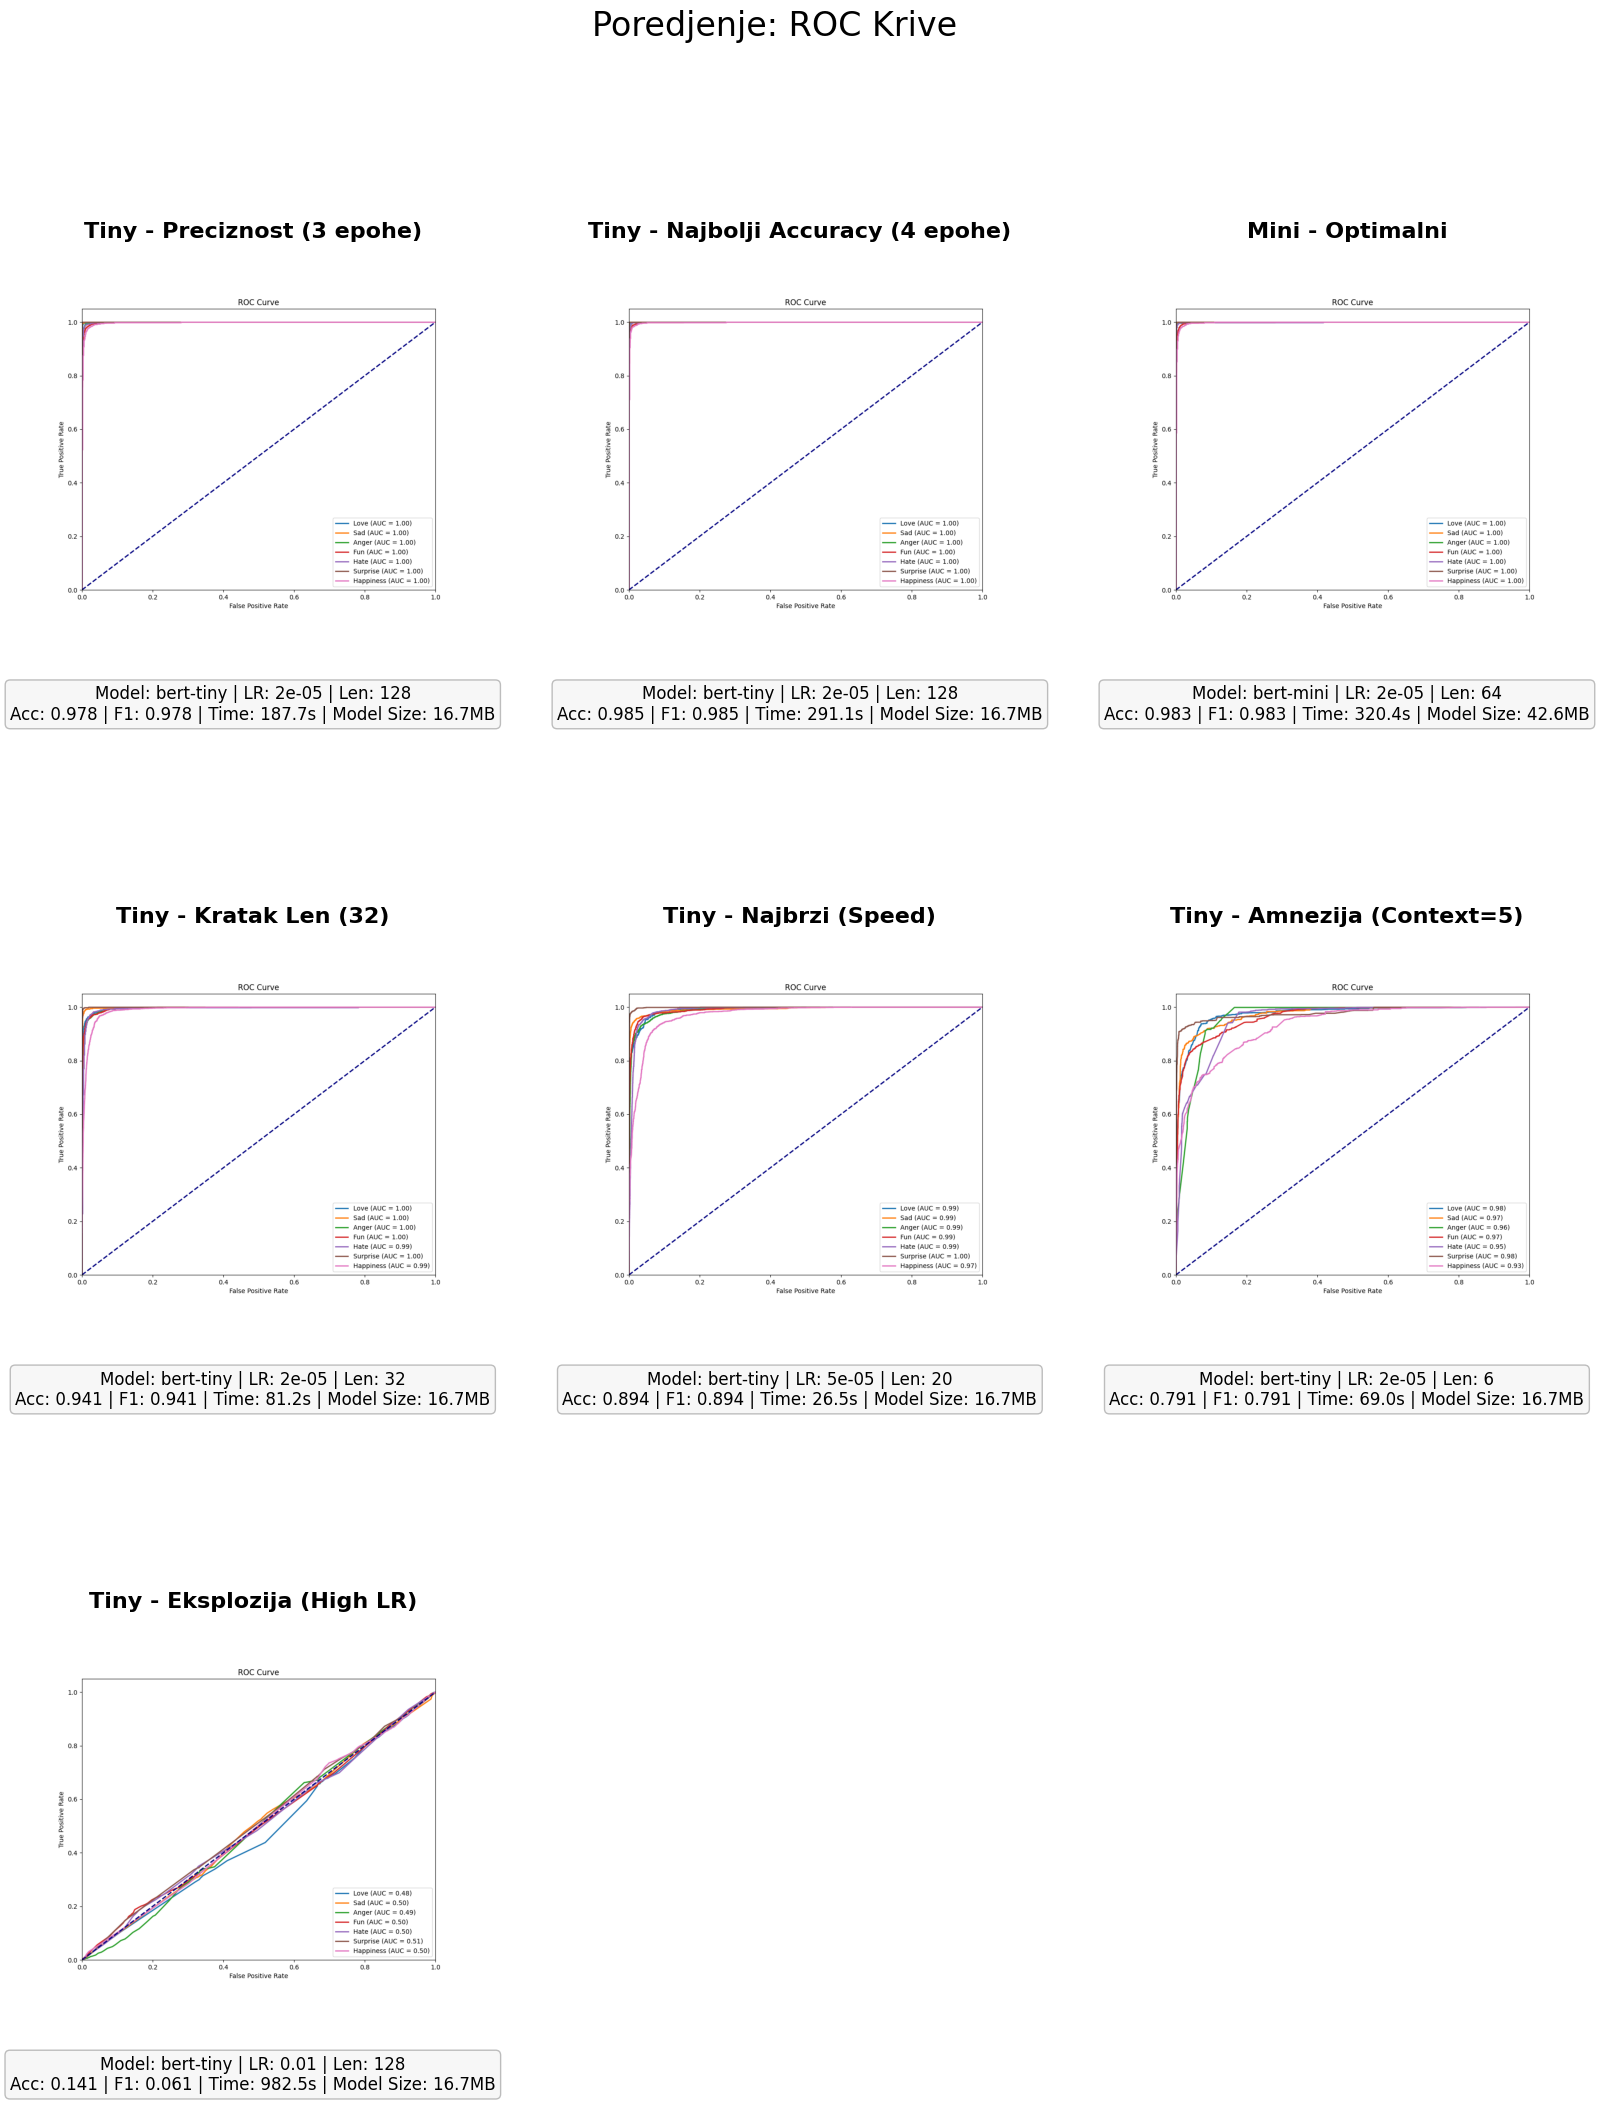

In [59]:
plot_grid(run_data, "roc_curve.png", "Poredjenje: ROC Krive")